# Jet Physics Dataset: A Walk-through

<b>Abstract</b> Large Hadron Collider is pushing for higher energy of collisions. The current objective is to collect 10 times more data than in the initial design by around 2030. This urges the experiments to implement more complex algorithms early in physics event selection process. We exploit fast inference neural networks suitable for the implementation in the Compact Muon Solenoid trigger system. Our case study is a jet detection using calorimeter energy deposit.

This file provides background on jets, calorimeters, trigger system. It gives a general overview of the production of the dataset.

In [1]:
# Before starting import everything necessary

import getpass
import simplejson as json
import numpy as np
import os
import uproot

In [2]:
# Set presentation settings

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as tick

from matplotlib import cm
from matplotlib.colors import SymLogNorm
from mpl_toolkits import mplot3d

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (8.0, 5.0)

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Anonymous Pro for Powerline']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 16
matplotlib.rcParams["axes.titlesize"] = 14

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

with open('data/palette.json') as json_file:
    color_palette = json.load(json_file)

In [3]:
# Get access to files in EOS

os.system("echo %s | kinit" % getpass.getpass())

········


0

## Jets

A jet is a collimated spray of particles. Used to probe the underlying elementary particle that initiates the cascade of particles.

In [4]:
# Define quarks mass, in GeV
q_mass = {'b': 4.18, 'q': 0.096, 't': 173.1, 'W': 80.39, 'h': 124.97}

# Define radius of a jet
delta_R = {'b': 0.4, 'q': 0.4, 't': 0.8, 'W': 0.8, 'h': 0.8}

In [5]:
JSON_OUT_DIR = 'data/file-configuration.json'

with open(JSON_OUT_DIR, 'r') as f:
    config = json.loads(f.read())

In [6]:
# Available jets

for jet in ['bb', 'tt', 'hh', 'WW']:
    print('%s: %s events, %s jets, %s jets per event' %
          (jet,
           config[jet]['events'],
           config[jet]['jets'],
           round(config[jet]['jets']/config[jet]['events'], 2)))

bb: 769973 events, 3738320 jets, 4.86 jets per event
tt: 940000 events, 1945845 jets, 2.07 jets per event
hh: 990000 events, 2111569 jets, 2.13 jets per event
WW: 911000 events, 2056696 jets, 2.26 jets per event


## Calorimeters

Calorimeters are devices that measure the energy of the particles. Neutral particles (e.g. photons) are not visible in tracking devices but revealed by the energy deposit they leave in the calorimeters. CMS has two types of calorimeters: electromagentic (ECAL) and hadron (HCAL). ECAL is made of 76000 scintillating PbWO$_4$ crystals. ECAL absorbs elections and photons. Hadrons begin to lose energy in ECAL only to be stopped in HCAL.

Number of Towers: 2832


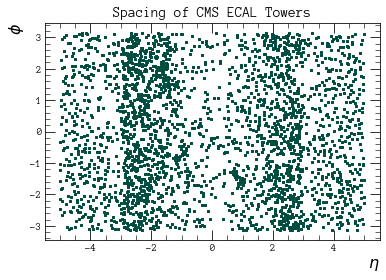

In [7]:
# Placement of crystals

file = uproot.open("/eos/project/d/dshep/CEVA/RSGraviton_WW_NARROW/RSGraviton_WW_NARROW_0.root")

print("Number of Towers: %s" % (file['Delphes']['Tower']['Tower.Phi'].array()[0].shape[0]))

plt.xlabel('$\eta$', horizontalalignment='right', x=1.0)
plt.ylabel('$\phi$', horizontalalignment='right', y=1.0)
plt.scatter(file['Delphes']['Tower']['Tower.Eta'].array()[0],
            file['Delphes']['Tower']['Tower.Phi'].array()[0],
            color=color_palette['teal']['shade_900'],
            marker='s', s=2);
plt.title('Spacing of CMS ECAL Towers')
plt.show();

We need to define grid edges of $\phi$ and $\eta$:

In [8]:
EDGES_PHI = []
for i in np.arange(-180, 180):
    EDGES_PHI.append(i * np.pi/180)
    
EDGES_ETA = []
for i in np.arange(0, 86):
    EDGES_ETA.append(-2.958 + i * 0.0174)
for i in np.arange(-84, 87):
    EDGES_ETA.append(i * 0.0174)
for i in np.arange(1, 85):
    EDGES_ETA.append(1.4964 + i * 0.0174)       
EDGES_ETA = sorted(EDGES_ETA)

## Trigger

Each event corresponds to around 1 MB in unprocessed form. The LHC operates at the rate of 40 million events per second. LHC is one of the largest sources of data in the world today. Trigger system selects interesting events due to storage constrains. Trigger system is essentially a hierarchical set of algorithms. The Level 1 (L1) Trigger, reduces the 40 MHz input to a 100 kHz rate. Implemented on FPGAs and ASCIs with approximately 3.2 $\mu$s to decide. High Level Trigger (HLT) scales the 100 kHz stream from L1 Trigger rate down to 1 kHz. It is a collision reconstruction software running on a computer farm of about one thousand commercial processors. The decision has to happen in approximately 100 ms.

Single-jet triggers are primarly designed to study quantum chromodynamics (QCD), but also be used for many analysis, such as searches for new physics. The L1 jet trigger use transverse momentum $P_T$ computed using both HCAL an ECAL in the central region $|\eta| < 3.0$. The regions $|\eta| > 3.0$ belong to forward calorimeter.

To calculate the minimal $P_T$ for a given $\Delta R$ for triggering the event, we can use the equation below:
$$\Delta R = \frac{2m}{P_T}$$

In [9]:
# Define minimum pt

min_pt = {}

for jtype, mass in q_mass.items():
    pt = 2*mass/delta_R[jtype]
    min_pt[jtype] = pt

In [10]:
# Define width of jets

WIDTH = {'b': 46, 'q': 46, 't': 92, 'W': 92, 'h': 92}

## Generating Input Dataset

In [11]:
# Plotting calorimeter energy deposit image

def plot_calo_image(energy, coordinates, pixels,
                    jtype, box_values, box_pts):
                    
    fig = plt.figure(figsize=(16, 8))
    ax1 = plt.subplot(121, projection='3d')
    ax2 = plt.subplot(122)

    cmap = matplotlib.cm.viridis
    colours = matplotlib.cm.viridis(energy/np.log10(max(energy)))

    width = depth = 3
    unzipped = list(zip(*coordinates))
    ax1.bar3d(unzipped[0],
             unzipped[1],
             np.zeros_like(energy),
             width,
             depth,
             energy,
             color=colours,
             shade=True)

    ax1.set_xlabel('$\phi [\degree$]')
    ax1.set_ylabel('$\eta$')
    ax1.set_zlabel('$E_T$ [GeV]')
    ax1.view_init(10, 40);

    # Plot calorimeter Pt and jets
    ax2 = plt.gca()
    ax2.set_xlim([-15, 356])
    ax2.set_xlabel('$\eta$', horizontalalignment='right', x=1.0)

    def foo(x, y):
        x = x - 46
        if x < 0:
            x = x + 360
        if x > 360:
            x = x - 360
        return int(x)

    ax2.yaxis.set_major_formatter(tick.FuncFormatter(foo))
    ax2.set_ylim([-15, 375+2*46])
    ax2.set_ylabel('$\phi [\degree$]', horizontalalignment='right', y=1.0)


    im = ax2.imshow(pixels,
                    norm=SymLogNorm(linthresh=0.03,
                                    vmin=0,
                                    vmax=pixels.max()),
                    interpolation="nearest",
                    cmap=cmap)

    cbar = fig.colorbar(im, extend='max')
    cbar.set_label('$E_T$ [GeV]', rotation=90, horizontalalignment='right', y=1.0)

    for center, pt in zip(box_values, box_pts):
        jet = patches.Rectangle((center[1]-WIDTH[jtype]/2, center[0]-WIDTH[jtype]/2),
                                WIDTH[jtype]+1,
                                WIDTH[jtype]+1,
                                linewidth=2,
                                edgecolor=color_palette['red']['shade_600'],
                                facecolor='none')
        ax2.add_patch(jet)
        ax2.text(center[1]-WIDTH[jtype]/2,
                 center[0]-WIDTH[jtype]/2,
                 '{}: {:.0f} GeV/c'.format(jtype, pt),
                 #size='x-large',
                 weight='bold',
                 color='#FAFAFA',
                 bbox={'facecolor': color_palette['red']['shade_900'], 'alpha': 1.0})

    ax2.text(0,
             1.04,
             "CMS",
             weight='bold',
             verticalalignment="top",
             horizontalalignment="left",
             transform=ax2.transAxes,
             color="black",
             fontsize=16)

    #ax2.title('Yeah')
    ax2.set_title('ECAL $E_T$ distribution with tagged jets', loc="right")

    plt.show();

In [12]:
# Generate data used for plotting
    
def data_generator(file_path, jtype):

    # First load values from file
    file = uproot.open(file_path)

    phis_full_file = file['Delphes']['Tower']['Tower.Phi'].array()
    etas_full_file = file['Delphes']['Tower']['Tower.Eta'].array()
    energy_full_file = file['Delphes']['Tower']['Tower.E'].array() # Energy
    is_ecal_full_file = file['Delphes']['Tower']['Tower.Eem'].array() # ECAL flag
    #is_hcal_full_file = file['Delphes']['Tower']['Tower.Ehad'].array() # HCAL flag
    
    bbox_pt_full_file = file['Delphes']['GenJet']['GenJet.PT'].array()
    bbox_eta_full_file = file['Delphes']['GenJet']['GenJet.Eta'].array()
    bbox_phi_full_file = file['Delphes']['GenJet']['GenJet.Phi'].array()
    
    for event_number in np.arange(NO_EVENTS, dtype=int):

        # Get ECAL mask
        ecal_mask = is_ecal_full_file[event_number] > 0
        
        # Load values for one event
        phis = phis_full_file[event_number][ecal_mask]
        etas = etas_full_file[event_number][ecal_mask]
        energy = energy_full_file[event_number][ecal_mask]

        # Filter only center of the calorimeter
        eta_mask = (etas > EDGES_ETA[0]) & (etas < EDGES_ETA[-1])
        phis = phis[eta_mask]
        etas = etas[eta_mask]
        energy = energy[eta_mask]

        # Map
        coordinates = []
        for eta, phi in zip(etas, phis):
            index_phi = np.argmax(EDGES_PHI > phi)
            index_eta = np.argmax(EDGES_ETA > eta) - 1
            coordinates.append((index_phi, index_eta))

        # Check if unique set of values
        if not len(list(set(coordinates))) == len(coordinates):
            import collections
            print(event_number)
            print([item for item, count in collections.Counter(coordinates).items() if count > 1])
            continue

        pixels = np.zeros((360, 340))
        for c, e in zip(coordinates, energy):
            pixels[c[0]][c[1]] = e
        
        # Extend image from top and bottom by delta R
        pixels = np.vstack((pixels[-46:,:], pixels, pixels[:46,:]))

        # Bounding boxes
        box_values = []
        box_pts = []
        
        bbox_pt = bbox_pt_full_file[event_number]
        bbox_eta = bbox_eta_full_file[event_number]
        bbox_phi = bbox_phi_full_file[event_number]
        
        for pt, eta, phi in zip(bbox_pt, bbox_eta, bbox_phi):
            if pt > min_pt[jtype]:
                index_phi = np.argmax(EDGES_PHI > phi)
                index_eta = np.argmax(EDGES_ETA > eta) - 1
                box_values.append((index_phi+46, index_eta))
                box_pts.append(pt)
        
        # Plot calorimeter energy deposit with highlighted jets
        plot_calo_image(energy, coordinates, pixels, jtype, box_values, box_pts)

b jets


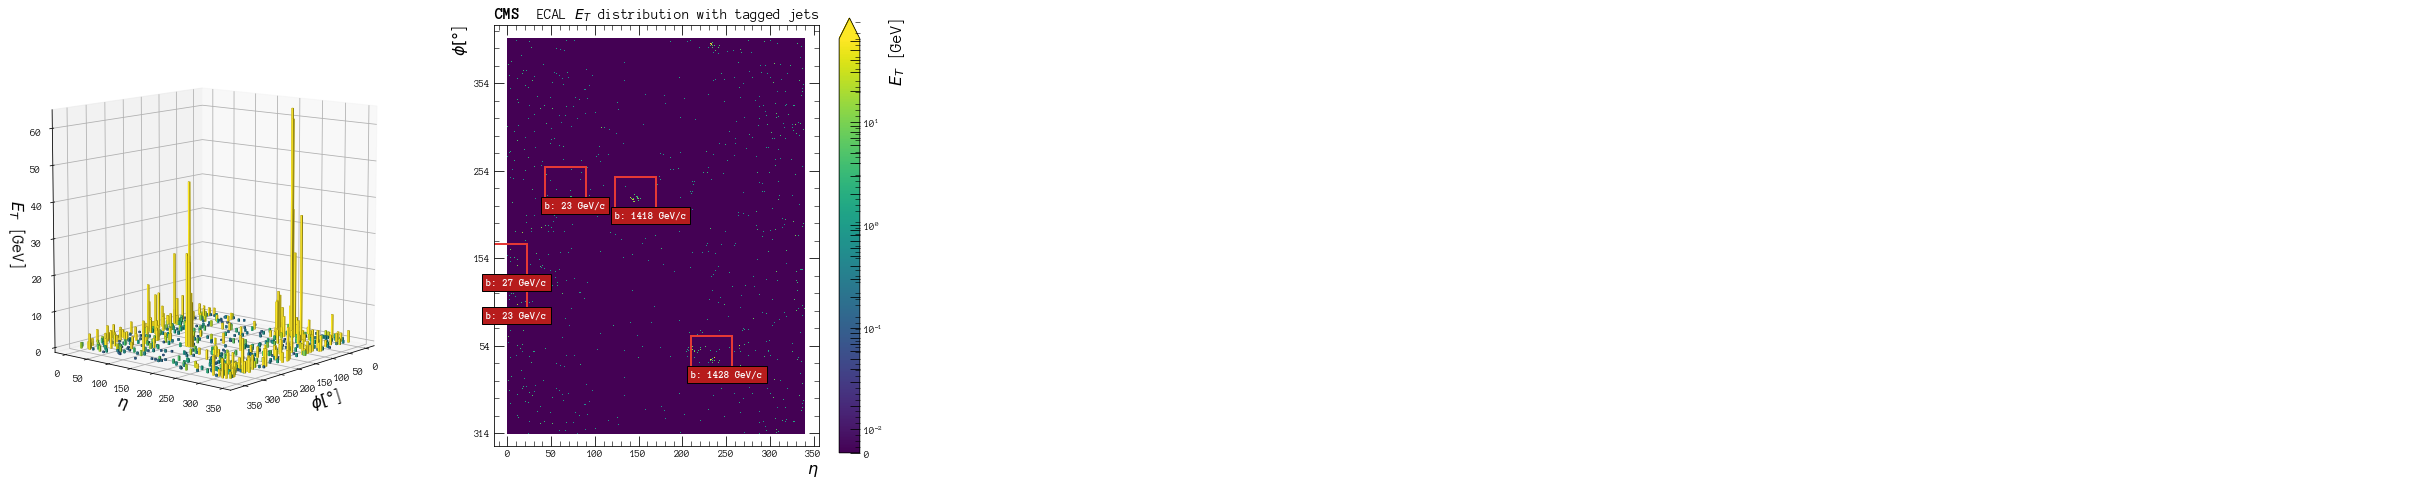

t jets


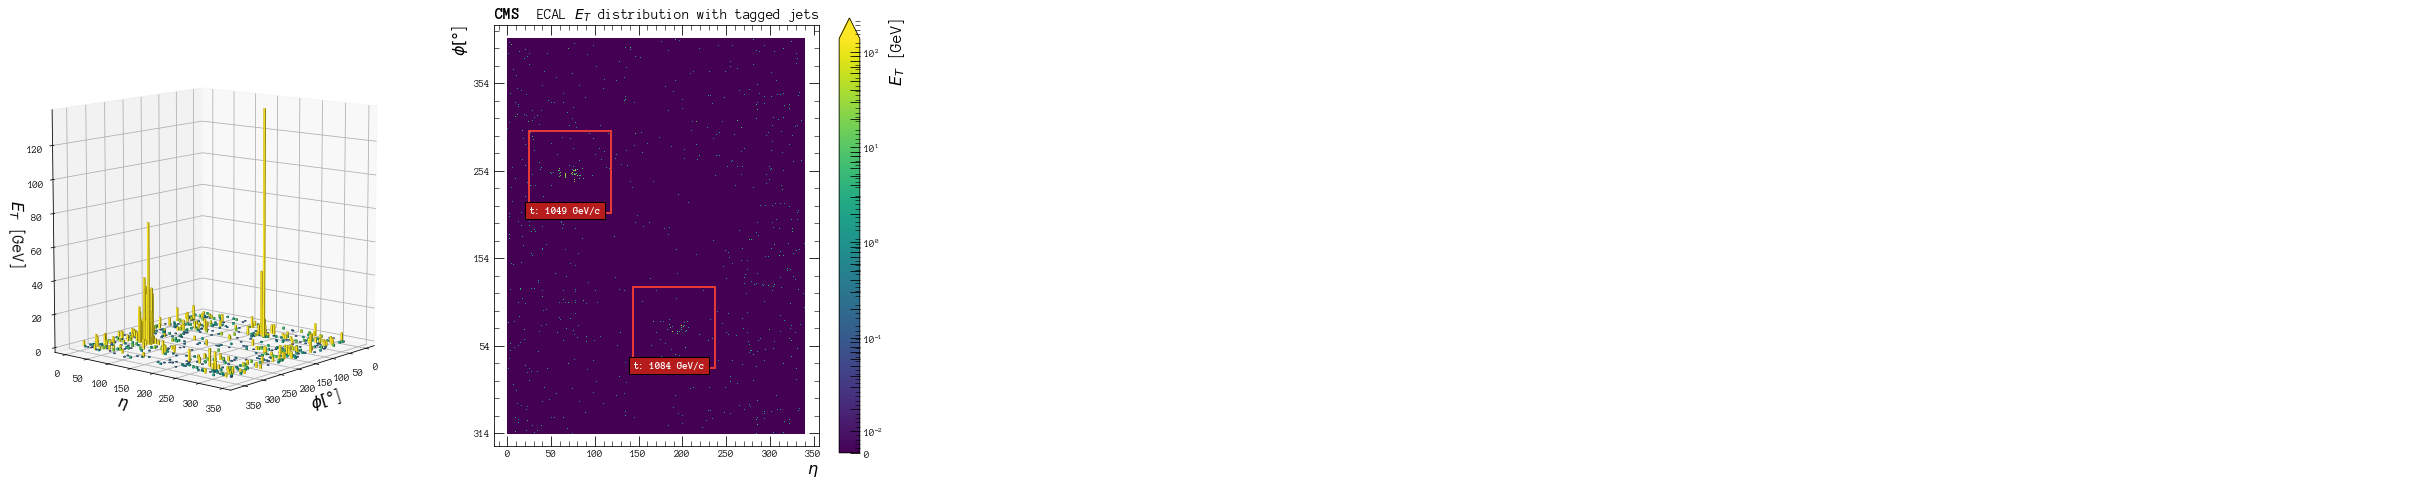

W jets


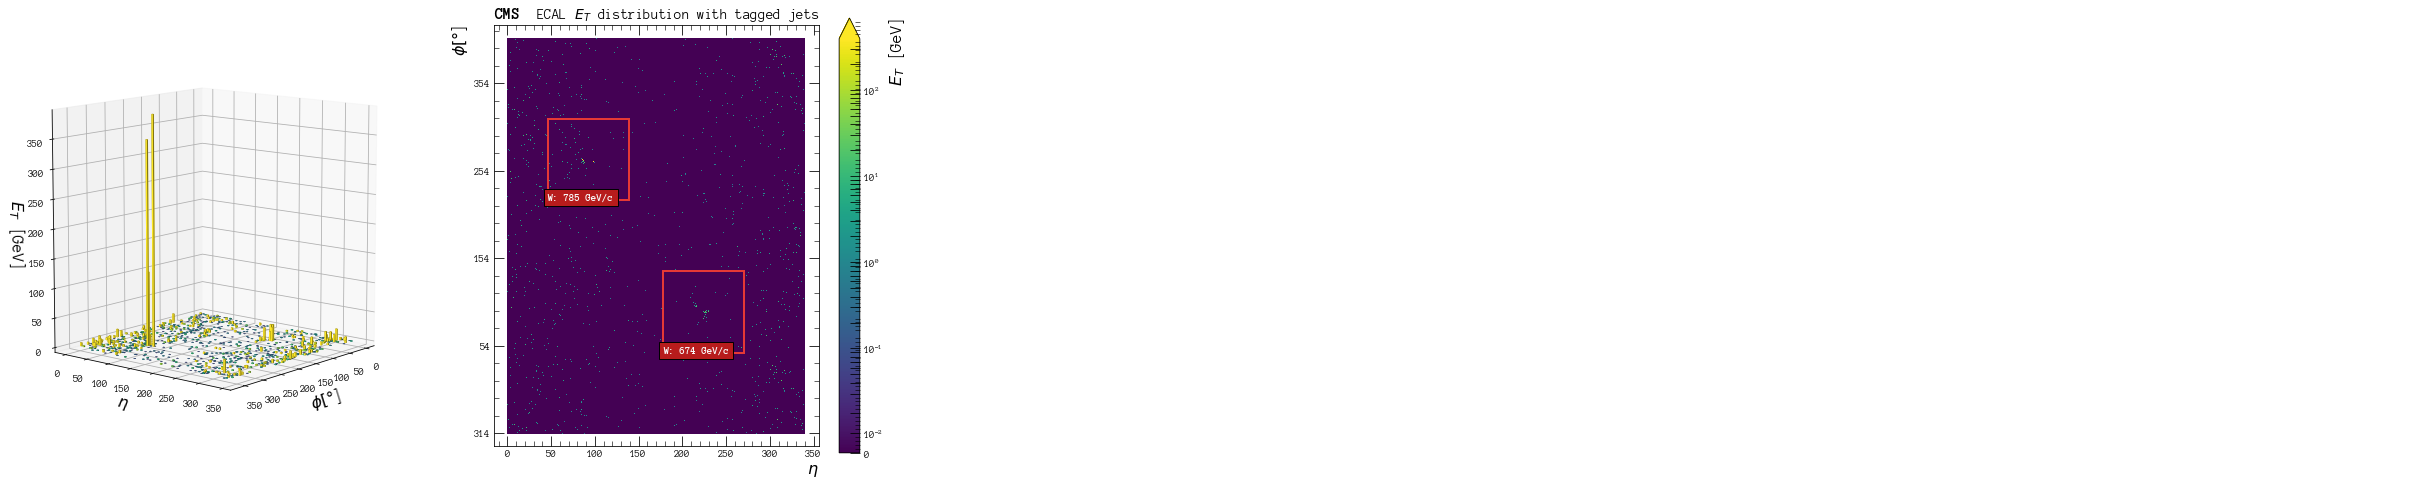

h jets


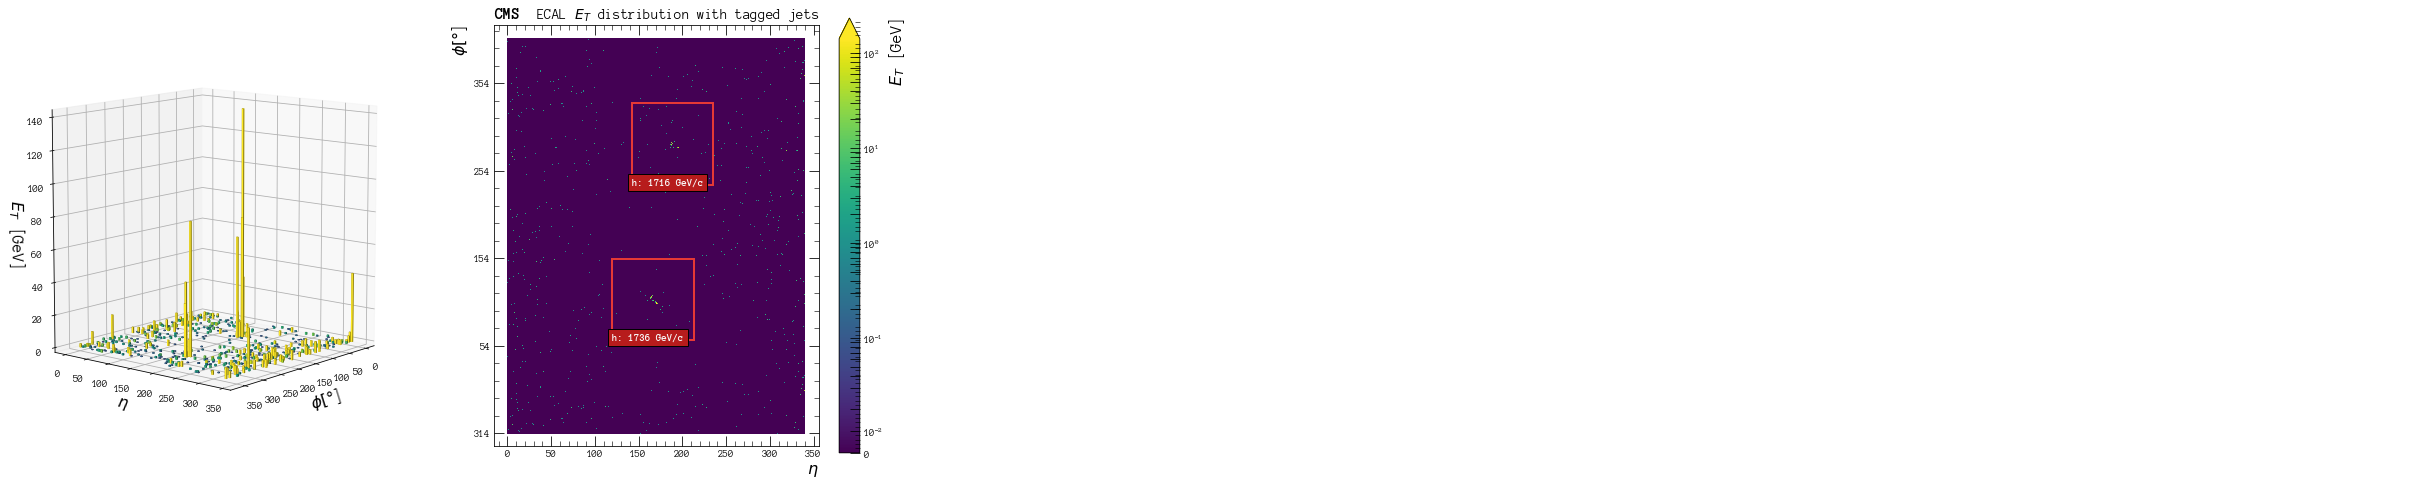

In [13]:
NO_EVENTS = 1

print('b jets')
data_generator("/eos/project/d/dshep/CEVA/RSGraviton_bb_NARROW/RSGraviton_bb_NARROW_0.root", 'b')
print('t jets')
data_generator("/eos/project/d/dshep/CEVA/RSGraviton_tt_NARROW/RSGraviton_tt_NARROW_0.root", 't')
print('W jets')
data_generator("/eos/project/d/dshep/CEVA/RSGraviton_WW_NARROW/RSGraviton_WW_NARROW_0.root", 'W')
print('h jets')
data_generator("/eos/project/d/dshep/CEVA/RSGraviton_hh_NARROW/RSGraviton_hh_NARROW_0.root", 'h')